<a href="https://colab.research.google.com/github/vivi1231/0814/blob/master/lymphoma_callbacks_tf_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [14]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

In [15]:
IMG_SIZE = 20
class_map = {'CLL':0, 'MCL': 1, 'FL': 2}

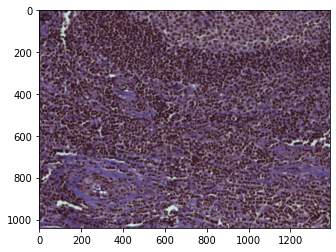

In [17]:
# Read single image
data_path = 'drive/My Drive/Day4/lymphoma/*/*.tif' 
img_paths = glob(data_path)
img_paths = np.random.choice(img_paths, 20) # demo for 200 images
img = cv2.imread(img_paths[0])
plt.imshow(img)

((1040, 1388, 3), (20, 20, 3))

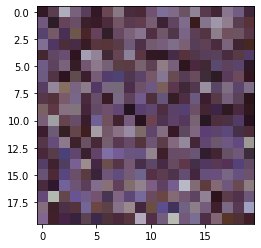

In [19]:
# Resize img
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [20]:
# Extract img class
img_path = img_paths[0]
img_path

'drive/My Drive/Day4/lymphoma/FL/sj-05-6124-R3_008.tif'

In [21]:
cls = img_path.split('/')[-2]
cls

'FL'

In [22]:
class_map[cls]

2

In [23]:
data_count = len(img_paths)
X = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))

In [24]:
for i, path in tqdm(enumerate(img_paths)):
    img = cv2.imread(path)
    img_resize = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    cls = path.split('/')[-2]
    
    X[i] = img_resize
    y[i] = class_map[cls]

In [25]:
# label count
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0., 1., 2.]), array([6, 7, 7]))

In [26]:
X = X/255
y_onehot = tf.keras.utils.to_categorical(y, num_classes=3)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=5566)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16, 20, 20, 3), (4, 20, 20, 3), (16, 3), (4, 3))

In [34]:
# 1
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = Conv2D(filters=16, kernel_size=3, activation='relu')(inputs)
x = Conv2D(filters=16, kernel_size=3, activation='relu')(x)
x = MaxPool2D(2)(x)
x = Flatten()(x)
x = Dense(64, activation=tf.keras.activations.relu)(x)
prediction = Dense(3, activation='softmax')(x)
model = Model(inputs=inputs, outputs=prediction)

In [35]:
# model.summary()

In [36]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [39]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('drive/My Drive/model.h5', monitor='val_loss', save_weights_only=False, save_best_only=True), # save the best one
    ModelCheckpoint('drive/My Drive/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5', 
                    monitor='val_loss', 
                    save_weights_only=False, 
                    save_best_only=True, ), # save if improved
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-8),
    CSVLogger('drive/My Drive/log.csv', separator=",", append=False)
]

In [38]:

logs = model.fit(X_train, y_train,
                batch_size=32,
                epochs=100000,
                verbose=1,
                callbacks=callbacks,     
                validation_data=(X_test, y_test))

Epoch 1/100000
1/1 [==============================] - 0s 313ms/step - loss: 1.1032 - accuracy: 0.3750 - val_loss: 1.1221 - val_accuracy: 0.2500
Epoch 2/100000
1/1 [==============================] - 0s 86ms/step - loss: 1.0689 - accuracy: 0.4375 - val_loss: 1.1107 - val_accuracy: 0.2500
Epoch 3/100000
1/1 [==============================] - 0s 84ms/step - loss: 1.0497 - accuracy: 0.3750 - val_loss: 1.1002 - val_accuracy: 0.2500
Epoch 4/100000
1/1 [==============================] - 0s 86ms/step - loss: 1.0289 - accuracy: 0.5000 - val_loss: 1.0884 - val_accuracy: 0.2500
Epoch 5/100000
1/1 [==============================] - 0s 84ms/step - loss: 1.0030 - accuracy: 0.5000 - val_loss: 1.0843 - val_accuracy: 0.5000
Epoch 6/100000
1/1 [==============================] - 0s 16ms/step - loss: 0.9792 - accuracy: 0.8125 - val_loss: 1.0870 - val_accuracy: 0.5000
Epoch 7/100000
1/1 [==============================] - 0s 16ms/step - loss: 0.9574 - accuracy: 0.7500 - val_loss: 1.0936 - val_accuracy: 0.500

In [ ]:
history = logs.history

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(y_true.shape, y_pred.shape)
target_names = [str(i) for i in range(3)]
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))
